In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T
import torchvision.datasets as D
from imgaug import augmenters as iaa
import imgaug as ia
import numpy as np

In [2]:
class MiRuido:
  def __init__(self):
    self.aug = iaa.SaltAndPepper(0.1)
    
  def __call__(self, img):
    img = np.array(img)
    return self.aug.augment_image(img)

In [3]:

dataset_train = D.FashionMNIST('./dataset', download=True, train=True, 
                               transform=T.ToTensor())
dataset_test = D.FashionMNIST('./dataset', download=True, train=False,
                              transform = T.ToTensor())

dataset_train_x = D.FashionMNIST('./dataset', download=False, train=True,
                                transform=T.Compose([MiRuido(),T.ToTensor()]))
dataset_test_x = D.FashionMNIST('./dataset', download=False, train=False,
                               transform=T.Compose([MiRuido(), T.ToTensor()]))

train_loader = torch.utils.data.DataLoader(dataset_train, 
                                           batch_size=16, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset_test, 
                                           batch_size=16, shuffle=False)

train_loader_x = torch.utils.data.DataLoader(dataset_train_x, 
                                           batch_size=16, shuffle=False)
test_loader_x = torch.utils.data.DataLoader(dataset_test_x, 
                                           batch_size=16, shuffle=False)

Extracting ./dataset/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./dataset/FashionMNIST/raw


Extracting ./dataset/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./dataset/FashionMNIST/raw


Extracting ./dataset/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./dataset/FashionMNIST/raw


Extracting ./dataset/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./dataset/FashionMNIST/raw
Processing...
Done!




/opt/conda/conda-bld/pytorch_1591914794252/work/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


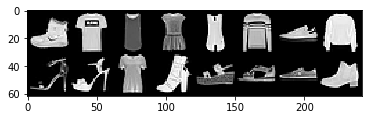

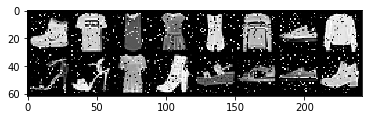

In [4]:
#Inspeccion
it1 = iter(train_loader)
data1, target1 = next(it1)

it2 = iter(train_loader_x)
data2, target2 = next(it2)

import matplotlib.pyplot as plt

grid1 = torchvision.utils.make_grid(data1)
plt.imshow(grid1.permute(1, 2, 0))
plt.show()

grid2 = torchvision.utils.make_grid(data2)
plt.imshow(grid2.permute(1, 2, 0))
plt.show()




In [6]:
class NoiseAutoencoder(nn.Module):
  def __init__(self):
    super(NoiseAutoencoder, self).__init__()
    
    self.encoder = nn.Sequential(nn.Conv2d(1, 16, kernel_size=3, padding=1),
                                nn.ReLU(),
                                nn.MaxPool2d(2,2),
                                nn.Conv2d(16, 32, kernel_size = 3, padding=1),
                                nn.ReLU(),
                                nn.MaxPool2d(2, 2),
                                nn.Conv2d(32, 16, kernel_size=3, padding=1),
                                nn.ReLU(),
                                nn.MaxPool2d(2, 2, padding=1))
    self.decoder = nn.Sequential(nn.Conv2d(16, 16, kernel_size=3, padding=1),
                                nn.ReLU(),
                                nn.Upsample(scale_factor=2),
                                nn.Conv2d(16,32, kernel_size=3, padding=1),
                                nn.ReLU(),
                                nn.Upsample(scale_factor=2),
                                nn.Conv2d(32, 64, kernel_size=3),
                                nn.ReLU(),
                                nn.Upsample(scale_factor=2),
                                nn.Conv2d(64, 1, kernel_size=3, padding=1))
    
  def forward(self, x):
    return self.decoder(self.encoder(x))
  

net = NoiseAutoencoder()
#net = net.to('cuda')
  
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr = 0.001)

In [8]:
for epoch in range(10):
  for x,y in zip(train_loader, train_loader_x):
    x = x[0]
    y = y[0]
    
    #x = x.to('cuda')
    #y = y.to('cuda')
    
    output = net(y)
    loss = criterion(output, x)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
  print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, 10, loss.item()))

Epoch [1/10], Loss: 0.0118
Epoch [2/10], Loss: 0.0095
Epoch [3/10], Loss: 0.0091
Epoch [4/10], Loss: 0.0085
Epoch [5/10], Loss: 0.0082
Epoch [6/10], Loss: 0.0081
Epoch [7/10], Loss: 0.0080
Epoch [8/10], Loss: 0.0077
Epoch [9/10], Loss: 0.0079
Epoch [10/10], Loss: 0.0073


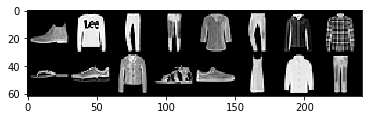

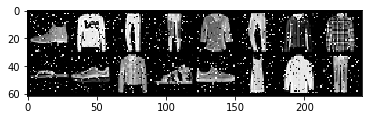

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


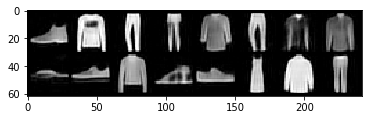

In [10]:
data1,_ = next(iter(test_loader))
data2,_ = next(iter(test_loader_x))

with torch.no_grad():
  out = net(data2)
  
grid1 = torchvision.utils.make_grid(data1)
plt.imshow(grid1.permute(1, 2, 0))
plt.show()

grid2 = torchvision.utils.make_grid(data2)
plt.imshow(grid2.permute(1, 2, 0))
plt.show()

grid3 = torchvision.utils.make_grid(out.cpu())
plt.imshow(grid3.permute(1, 2, 0))
plt.show()
  


In [ ]:
!wget http://www.ivan-sipiran.com/downloads/noisy_docs_data.zip

In [ ]:
!unzip noisy_docs_data.zip

In [ ]:
import cv2

img = cv2.imread('noisy_docs_data/train_cleaned/101.png')
plt.imshow(img)
plt.show()

In [ ]:
import PIL
import glob

class MiDataset(torch.utils.data.Dataset):
  def __init__(self, root, tform=None, imgloader=PIL.Image.open):
    super(MiDataset, self).__init__()
    
    self.root = root
    self.filenames = sorted(glob.glob(root + '/*.png'))
    self.tform = tform
    self.imgloader = imgloader
    
  def __len__(self):
    return len(self.filenames)
  
  def __getitem__(self, i):
    out = self.imgloader(self.filenames[i])
    if self.tform:
      out = self.tform(out)
    return out

In [ ]:
doc_train_dataset = MiDataset(root='noisy_docs_data/train',
                             tform=T.Compose([T.Resize((258, 540)), 
                                              T.ToTensor()]))

doc_train_loader = torch.utils.data.DataLoader(doc_train_dataset,
                                               batch_size=4)

doc_target_dataset = MiDataset(root='noisy_docs_data/train_cleaned',
                             tform=T.Compose([T.Resize((258, 540)), 
                                              T.ToTensor()]))

doc_target_loader = torch.utils.data.DataLoader(doc_target_dataset,
                                               batch_size=4)

In [ ]:
class BackgroundRemoval(nn.Module):
  def __init__(self):
    super(BackgroundRemoval, self).__init__()
    
    self.encoder = nn.Sequential(
        nn.Conv2d(1, 64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2))
    
    self.decoder = nn.Sequential(
        nn.Conv2d(64, 64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Upsample(scale_factor=2),
        nn.Conv2d(64, 1, kernel_size=3, padding=1))
    
  def forward(self,x):
    return self.decoder(self.encoder(x))
  
net2 = BackgroundRemoval()
net2 = net2.to('cuda')
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net2.parameters(), lr=0.001)


In [ ]:
for epoch in range(100):
  for x,y in zip(doc_train_loader, doc_target_loader):
    x = x.to('cuda')
    y = y.to('cuda')
    
    output = net2(x)
    loss = criterion(output, y)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
  print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, 10, loss.item()))

In [ ]:
doc_test_dataset = MiDataset(root='noisy_docs_data/test',
                             tform=T.Compose([T.Resize((258, 540)), 
                                              T.ToTensor()]))

doc_test_loader = torch.utils.data.DataLoader(doc_test_dataset,
                                               batch_size=4)

data3 = next(iter(doc_test_loader))
grid3 = torchvision.utils.make_grid(data3, nrow=1)
plt.figure(figsize=(12, 12))
plt.imshow(grid3.permute(1, 2, 0))
plt.show()

In [ ]:
with torch.no_grad():
  out = net2(data3.to('cuda'))
  
grid4 = torchvision.utils.make_grid(out.cpu(), nrow=1)
plt.figure(figsize=(12, 12))
plt.imshow(grid4.permute(1, 2, 0))
plt.show()